## 1. Data Collection
***
Here I used the NYTs API to collect article information that had any mention of the word "dog" in the headline and body from the years 1950 to 2020. Check out https://developer.nytimes.com/ for more information on available data and tools that the NYT provides.

## 2. Data Exploration and Cleaning
***
First just to get a sense of what our data looked like:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

data = pd.read_csv("../DogNews/nyt_1950_2020.csv")
data.head()

,headline,date,document_type,type_of_material,section_name,keywords,snippet,source,lead_paragraph
0,UPSTATE DOG WINS IN SPRINGER TRIALS,1964-04-05,article,Archives,Archives,[],NaN,The New York Times,"CARVERSVILLE, Pa. April 4—Toodry March Brown, ..."
1,POINTER CAPTURES SHOOTING DOG STAKE,1964-10-26,article,Archives,Archives,[],NaN,The New York Times,"MEDFORD, N. J., Oct. 25—Tip Top Timmy, a point..."
2,DOG LEADS POLICE TO KILLING SUSPECT,1964-12-22,article,Archives,Archives,[],NaN,The New York Times,A dog last night led two detectives to a 16‐ye...
3,DOG FANCIERS SEEM TO FORGIVE JOHNSON,1964-05-02,article,Archives,Archives,['Animals'],Dog fanciers seen ready to forgive Johnson for...,The New York Times,"WASHINGTON, May 1 (UPI) — Dog fanciers were ap..."
4,Afghan Dominates Chicago Dog Show,1964-04-05,article,Archives,Archives,"['Automobiles', 'SHOWS (INTERNATIONAL)']",special sec on show,The New York Times,"CHICAGO, April 4 — An Afghan endowed with rare..."


We also had to do some reformation and remove missing data along with duplicate data, for more details look at the Data Exploration and Cleaning file

In [2]:
# change date to type datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
# drop any empty lead paragraphs
data.dropna(subset=['lead_paragraph'], inplace=True)
# drop snippet column
data.drop(columns=['snippet'], inplace=True)
# drop duplicates
lead_paragraph = data['lead_paragraph']
data.drop_duplicates(subset='lead_paragraph', keep='last', inplace=True)

headline = data['headline']
data.drop_duplicates(subset=['headline', 'date'], keep='last', inplace=True)

## 3. Data Visualization
***

Text(0, 0.5, 'Count')

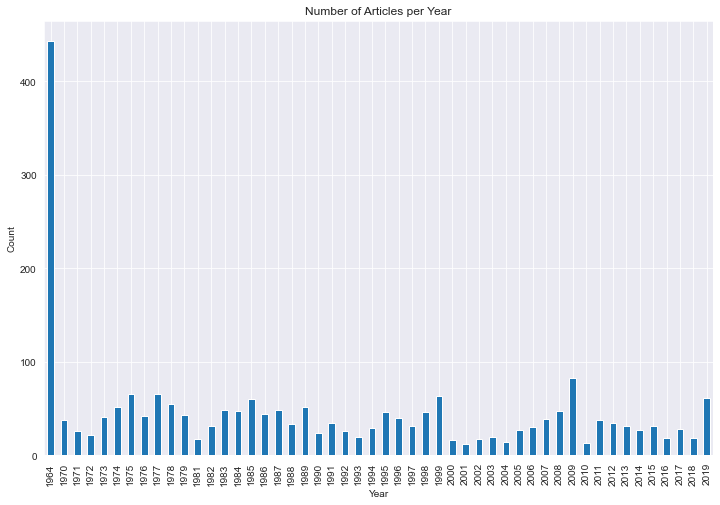

In [4]:
year_amount= data.groupby(data['date'].rename('Years').dt.year).size()
year_amount.plot(kind='bar', figsize=(12, 8))
plt.title('Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Count')

We can see that there are a disproportionate number of articles from 1964, which in the future we could collect more data to get rid of any possible bias, but since we are not making any predictive models it should not be an issue.

Text(0, 0.5, 'Count')

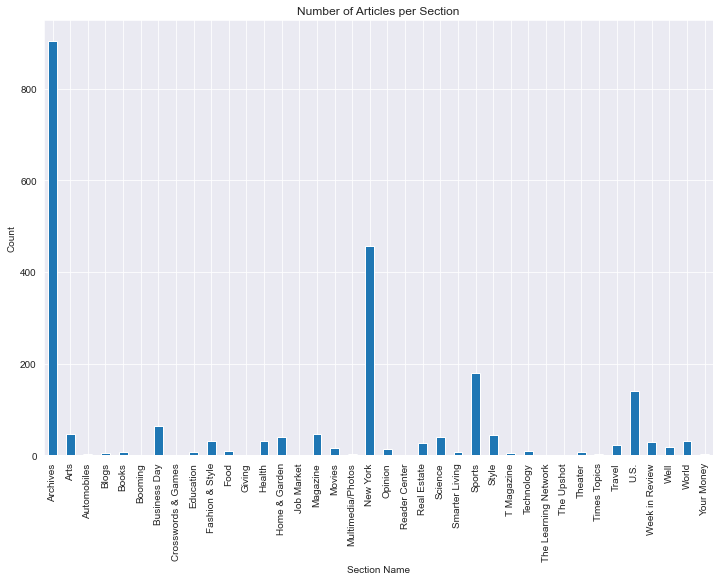

In [5]:
section_amount= data.groupby(data['section_name']).size()
section_amount.plot(kind='bar', figsize=(12, 8))
plt.title('Number of Articles per Section')
plt.xlabel('Section Name')
plt.ylabel('Count')

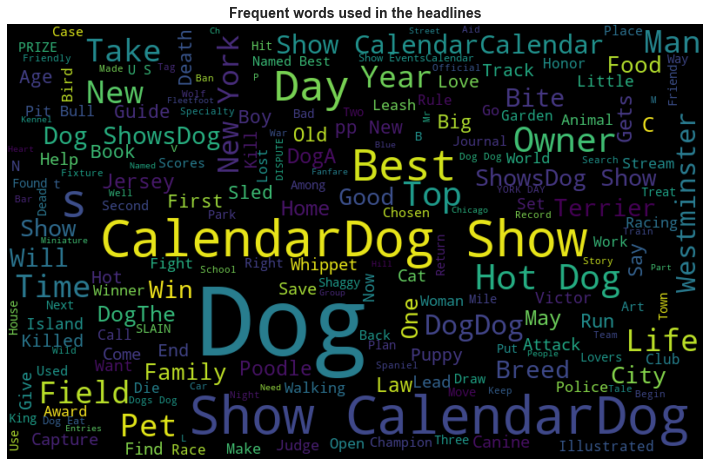

In [6]:
from wordcloud import WordCloud
all_words = ''.join([word for word in data['headline']])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Frequent words used in the headlines", weight='bold', fontsize=14)
plt.show()

Here looking at headlines, we see that we have mentions of words like "show", "breed" and "Terrier". Words we would expect in this topic

## 4. Text Processing
***
Next in order to use models like Word2Vec, we need to further process our text, we will remove punctuation, numbers and stemming along with

In [10]:
import re
import nltk
def process_text(text):
    # convert to lowercase, remove punctuations and characters and strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    #remove digits
    text = ''.join(i for i in text if not i.isdigit())
    # tokenize
    text_lst = text.split()
    # remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    text_lst = [word for word in text_lst if word not in stopwords]

    # stemming (remove -ing, -ly, ...)
    ps = nltk.stem.porter.PorterStemmer()
    text_lst = [ps.stem(word) for word in text_lst]

    # lemmatisation (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    text_lst = [lem.lemmatize(word) for word in text_lst]

    # convert back to string from list
    text = " ".join(text_lst)
    return text
data["lead_paragraph_clean"] = data["lead_paragraph"].apply(lambda x: process_text(x))
data["headline_clean"] = data["headline"].apply(lambda x: process_text(x))
data.head()

,headline,date,document_type,type_of_material,section_name,keywords,source,lead_paragraph,lead_paragraph_clean,headline_clean
0,UPSTATE DOG WINS IN SPRINGER TRIALS,1964-04-05,article,Archives,Archives,[],The New York Times,"CARVERSVILLE, Pa. April 4—Toodry March Brown, ...",carversvil pa april toodri march brown monthol...,upstat dog win springer trial
1,POINTER CAPTURES SHOOTING DOG STAKE,1964-10-26,article,Archives,Archives,[],The New York Times,"MEDFORD, N. J., Oct. 25—Tip Top Timmy, a point...",medford n j oct tip top timmi pointer own fred...,pointer captur shoot dog stake
2,DOG LEADS POLICE TO KILLING SUSPECT,1964-12-22,article,Archives,Archives,[],The New York Times,A dog last night led two detectives to a 16‐ye...,dog last night led two detect yearold boy seiz...,dog lead polic kill suspect
3,DOG FANCIERS SEEM TO FORGIVE JOHNSON,1964-05-02,article,Archives,Archives,['Animals'],The New York Times,"WASHINGTON, May 1 (UPI) — Dog fanciers were ap...",washington may upi dog fancier appar readi tod...,dog fancier seem forgiv johnson
4,Afghan Dominates Chicago Dog Show,1964-04-05,article,Archives,Archives,"['Automobiles', 'SHOWS (INTERNATIONAL)']",The New York Times,"CHICAGO, April 4 — An Afghan endowed with rare...",chicago april afghan endow rare gift bench com...,afghan domin chicago dog show


## 5. Word2Vec
***

In [11]:
from gensim.models import Word2Vec
tokens = data["lead_paragraph_clean"].apply(lambda x: nltk.word_tokenize(x))
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=8, min_count=100, alpha=0.03,seed=42, workers=4)
vocab=w2v_model.wv.key_to_index

First we must note that our model is relatively small. We only have 47 words in our vocabulary which we can see below

In [17]:
print(vocab)

{'dog': 0, 'show': 1, 'new': 2, 'year': 3, 'club': 4, 'today': 5, 'one': 6, 'kennel': 7, 'last': 8, 'said': 9, 'mr': 10, 'day': 11, 'york': 12, 'two': 13, 'citi': 14, 'owner': 15, 'yesterday': 16, 'time': 17, 'pet': 18, 'first': 19, 'like': 20, 'th': 21, 'obedi': 22, 'state': 23, 'park': 24, 'breed': 25, 'street': 26, 'polic': 27, 'name': 28, 'peopl': 29, 'night': 30, 'anim': 31, 'yearold': 32, 'week': 33, 'n': 34, 'man': 35, 'would': 36, 'may': 37, 'home': 38, 'best': 39, 'say': 40, 'american': 41, 'run': 42, 'counti': 43, 'allbre': 44, 'westminst': 45, 'mani': 46}


Now we can play around with this model. For example, we might want to see which words are most similar to dog.

In [19]:
w2v_model.wv.most_similar(positive = ['dog'], topn = 5)

[('show', 0.9988687038421631),
 ('breed', 0.9987440705299377),
 ('one', 0.9986959099769592),
 ('th', 0.9986342787742615),
 ('year', 0.9986186623573303)]

## 6. Topic Modeling Using LDA
***


First we create a "bow_corpus" from a dictionary of around 700 words, which gives us how many words and how many times those words appear. Notice in this step we also got rid of any extreme results such as words like "the" or words that almost never show up.

In [25]:
import gensim
from gensim import corpora, models
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# Create doc2bow dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in tokens]

Dictionary<691 unique tokens: ['april', 'best', 'brown', 'championship', 'club']...>


Next we want to use this bow-corpus to create a tf-idf model. This model uses the frequency of words to determine how relevant those words are to a given document.

In [ ]:
# Create TFIDF model
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

Lastly we can create a topic model, that is can we categorize our words into distinct topics. This method uses matrix factorization similar to PCA. Notice that since we only have a small amount of data we are only going to look at 4 topics.

In [26]:
# LDA model
if __name__ == '__main__':
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
    for idx, topic in lda_model_tfidf.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"polic" + 0.008*"year" + 0.006*"show" + 0.006*"today" + 0.006*"new" + 0.006*"last" + 0.006*"said" + 0.006*"club" + 0.005*"two" + 0.005*"yesterday"
Topic: 1 Word: 0.010*"new" + 0.007*"club" + 0.007*"today" + 0.007*"show" + 0.007*"year" + 0.006*"day" + 0.006*"one" + 0.006*"kennel" + 0.006*"york" + 0.006*"th"
Topic: 2 Word: 0.007*"like" + 0.006*"state" + 0.006*"new" + 0.006*"life" + 0.006*"yearold" + 0.005*"show" + 0.005*"one" + 0.005*"year" + 0.005*"today" + 0.005*"first"
Topic: 3 Word: 0.012*"show" + 0.011*"allbre" + 0.011*"obedi" + 0.010*"kc" + 0.009*"club" + 0.007*"today" + 0.007*"new" + 0.007*"pm" + 0.006*"th" + 0.006*"rout"
